In [2]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset, random_split
import torchvision.datasets as datasets
%matplotlib inline

In [73]:
# 1.0 -- T больше Т_с
# 0.0 -- T меньше Т_с

def labels_modif(y, num_conf):
    y_mod = np.empty((num_conf,2))
    for i in range(y.shape[0]):
        if y[i] == 1.0:
            y_mod[i, 0] = 0.0
            y_mod[i, 1] = 1.0
        else:
            y_mod[i, 0] = 1.0
            y_mod[i, 1] = 0.0
    return y_mod

In [74]:
def load_data(Jd, l, num_conf, T, num_temps, batch_size, shuffle_opt, opt='train'):
    datasets = []
    for j in range(num_temps):

        with open(f'data_spins/{Jd}_{opt}/spins_{l}_{T[j]}.npy', 'rb') as f:
            x = np.load(f)    
        with open(f'data_spins/{Jd}_{opt}/answ_{l}_{T[j]}.npy', 'rb') as f:
            y = np.load(f)
        
        y = labels_modif(y, num_conf)

        tensor_x = torch.Tensor(x).unsqueeze(1)
        tensor_y = torch.from_numpy(y).type(torch.float32)

        datasets.append(TensorDataset(tensor_x, tensor_y))


    dataset = torch.utils.data.ConcatDataset(datasets)

    return DataLoader(dataset, batch_size=batch_size, shuffle = shuffle_opt)

In [75]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 64, 2)
        self.pool = nn.MaxPool2d(2, 2)
        self.act_hid = nn.ReLU()
        self.fc1 = nn.Linear(64*int(l/2-1)*int(l/2-1), 64)
        self.fc2 = nn.Linear(64, 2)

    def forward(self, x):
        x = self.conv1(x)
        x = self.pool(x)
        x = self.act_hid(x)
        x = x.view(-1, 64*int(l/2-1)*int(l/2-1))
        x = self.fc1(x)
        x = self.act_hid(x)
        x = self.fc2(x)
        return x

In [97]:
def train(train_dataloader, num_epoch, criterion, batch_size):
    model = Net()
    optimizer = torch.optim.Adam(model.parameters(), lr=1.0e-4)
    act = nn.Softmax(dim=1)

    for epoch in range(num_epoch):  
        running_loss = 0.0
        accuracy = 0.0
        pbar = tqdm(enumerate(train_dataloader), total=len(train_dataloader))
        for i, data in pbar:
            inputs, labels = data

            optimizer.zero_grad()
            outputs = model(inputs)
            outputs = act(outputs)
            #outputs = outputs.squeeze(1) # к одной размерности с labels
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            accuracy += (batch_size - sum(abs(labels - outputs))).float().mean()

            pbar.set_description(
                    f"Loss: {running_loss/((i+1)*batch_size)} "
                    f"Accuracy: {accuracy * 100  / ((i+1)*batch_size)}"
            )

    print('Training completed')
    return model

In [98]:
def testing(model, test_dataloader, criterion, batch_size):
    outp = []
    errors = []
    accuracy = 0.0
    act = nn.Softmax(dim=1)
    with torch.no_grad():
        for i, data in enumerate(test_dataloader):
            inputs, labels = data
            outputs = model(inputs)
            outputs = act(outputs)
            #outputs = outputs.squeeze(1)
            outp.append(outputs)
            loss = criterion(outputs, labels)
            errors.append(loss.item())

            accuracy += (1 - sum(abs(labels - outputs))).float().mean()

    print("Test accuracy = {}".format(accuracy / len(test_dataloader)))
    return outp, errors

In [82]:
roots = [2.2691853142129728, 2.104982167992544, 1.932307699120554, 1.749339162933206, 1.5536238493280832, 1.34187327905057, 1.109960313758399, 0.8541630993606272, 0.5762735442012712, 0.2885386111960936, 0.03198372863548067]
jds = [0.0, -0.1, -0.2, -0.3, -0.4, -0.5, -0.6, -0.7, -0.8, -0.9, -1.0]
get_crit_T = dict(zip(jds, roots))
num_temps = 20
Jd = 0.0
T_c = get_crit_T[Jd]
T = np.linspace(T_c - 1.0, T_c + 1.0, num_temps)

L = [10, 20, 30, 40]
num_conf_tr = 2048
num_conf_ts = 512
num_epoch = 1
errors = []
outputs = []

criterion = nn.BCEWithLogitsLoss()     

#for i in range(1):    
for i in range(len(L)):
    l = L[i]
    train_dataloader = load_data(Jd, l, num_conf_tr, T, num_temps, batch_size=4, True, opt='train')
    print(f'Start training for L = {l}')
    model = train(train_dataloader, num_epoch, criterion, batch_size=4)
    test_dataloader = load_data(Jd, l, num_conf_ts, T, num_temps, batch_size=1, False, opt='test')
    outp_i, errors_i = testing(model, test_dataloader, criterion, batch_size=1)
    outputs.append(outp_i)
    errors.append(errors_i)

Start training for L = 10


Loss: 0.13754339692677603 Accuracy: 89.95700073242188: 100%|██████████| 10240/10240 [00:33<00:00, 306.45it/s]


Training completed
Accuracy = 0.9156983494758606
Start training for L = 20


Loss: 0.13094843050494093 Accuracy: 95.62812805175781: 100%|██████████| 10240/10240 [01:06<00:00, 154.35it/s]


Training completed
Accuracy = 0.9490745663642883
Start training for L = 30


Loss: 0.1520268108404707 Accuracy: 78.97549438476562: 100%|██████████| 10240/10240 [02:48<00:00, 60.83it/s] 


Training completed
Accuracy = 0.6419950723648071
Start training for L = 40


Loss: 0.12805327167880023 Accuracy: 98.10804748535156: 100%|██████████| 10240/10240 [03:57<00:00, 43.18it/s]


Training completed
Accuracy = 0.984479546546936


In [83]:
err_10 = [sum(errors[0][i*512:(i+1)*512])/512 for i in range(num_temps)]
err_20 = [sum(errors[1][i*512:(i+1)*512])/512 for i in range(num_temps)]
err_30 = [sum(errors[2][i*512:(i+1)*512])/512 for i in range(num_temps)]
err_40 = [sum(errors[3][i*512:(i+1)*512])/512 for i in range(num_temps)]

In [89]:
err_30 = [sum(errors[0][i*512:(i+1)*512])/512 for i in range(num_temps)]

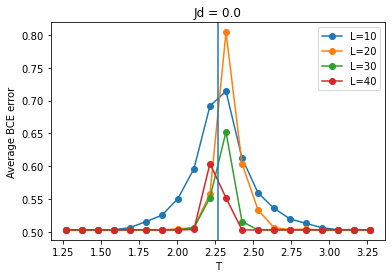

In [90]:
plt.plot(T, err_10, marker='o', label='L=10')
plt.plot(T, err_20, marker='o', label='L=20')
plt.plot(T, err_30, marker='o', label='L=30')
plt.plot(T, err_40, marker='o', label='L=40')
plt.title('Jd = 0.0')
plt.xlabel('T')
plt.ylabel('Average BCE error')
plt.axvline(x=T_c)
plt.legend()
plt.show()

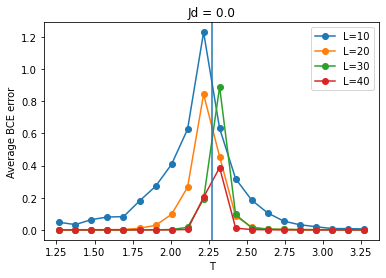

In [17]:
# without activation in loss calculation

plt.plot(T, err_10, marker='o', label='L=10')
plt.plot(T, err_20, marker='o', label='L=20')
plt.plot(T, err_30, marker='o', label='L=30')
plt.plot(T, err_40, marker='o', label='L=40')
plt.title('Jd = 0.0')
plt.xlabel('T')
plt.ylabel('Average BCE error')
plt.axvline(x=T_c)
plt.legend()
plt.show()

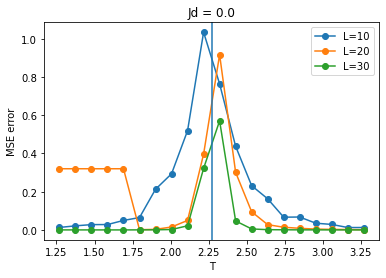

In [38]:
plt.plot(T, err_10, marker='o', label='L=10')
plt.plot(T, err_20, marker='o', label='L=20')
plt.plot(T, err_30, marker='o', label='L=30')
plt.title('Jd = 0.0')
plt.xlabel('T')
plt.ylabel('MSE error')
plt.axvline(x=T_c)
plt.legend()
plt.show()

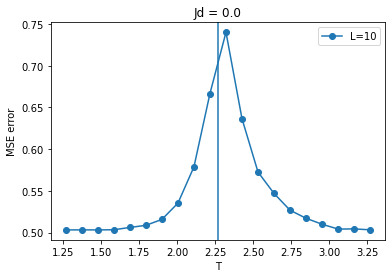

In [37]:
err_10 = [sum(errors[0][i*512:(i+1)*512])/512 for i in range(num_temps)]
plt.plot(T, err_10, marker='o', label='L=10')
plt.title('Jd = 0.0')
plt.xlabel('T')
plt.ylabel('MSE error')
plt.axvline(x=T_c)
plt.legend()
plt.show()

In [85]:
outp_10_0 = [sum([outputs[0][i*512:(i+1)*512][j][0][0] for j in range(512)])/512 for i in range(num_temps)]
outp_10_1 = [sum([outputs[0][i*512:(i+1)*512][j][0][1] for j in range(512)])/512 for i in range(num_temps)]

outp_20_0 = [sum([outputs[1][i*512:(i+1)*512][j][0][0] for j in range(512)])/512 for i in range(num_temps)]
outp_20_1 = [sum([outputs[1][i*512:(i+1)*512][j][0][1] for j in range(512)])/512 for i in range(num_temps)]

outp_30_0 = [sum([outputs[2][i*512:(i+1)*512][j][0][0] for j in range(512)])/512 for i in range(num_temps)]
outp_30_1 = [sum([outputs[2][i*512:(i+1)*512][j][0][1] for j in range(512)])/512 for i in range(num_temps)]

outp_40_0 = [sum([outputs[3][i*512:(i+1)*512][j][0][0] for j in range(512)])/512 for i in range(num_temps)]
outp_40_1 = [sum([outputs[][i*512:(i+1)*512][j][0][1] for j in range(512)])/512 for i in range(num_temps)]

In [91]:
outp_30_0 = [sum([outputs[0][i*512:(i+1)*512][j][0][0] for j in range(512)])/512 for i in range(num_temps)]
outp_30_1 = [sum([outputs[0][i*512:(i+1)*512][j][0][1] for j in range(512)])/512 for i in range(num_temps)]

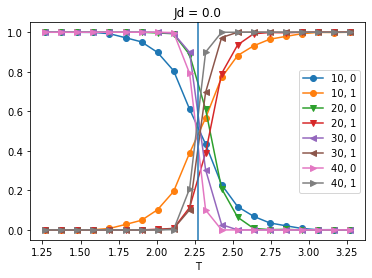

In [94]:
plt.plot(T, outp_10_0, marker='o', label='10, 0')
plt.plot(T, outp_10_1, marker='o', label='10, 1')

plt.plot(T, outp_20_0, marker='v', label='20, 0')
plt.plot(T, outp_20_1, marker='v', label='20, 1')

plt.plot(T, outp_30_0, marker='<', label='30, 0')
plt.plot(T, outp_30_1, marker='<', label='30, 1')

plt.plot(T, outp_40_0, marker='>', label='40, 0')
plt.plot(T, outp_40_1, marker='>', label='40, 1')

plt.title('Jd = 0.0')
plt.xlabel('T')
#plt.ylabel('MSE error')
plt.axvline(x=T_c)
plt.legend()
plt.show()

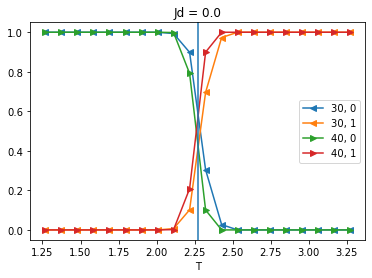

In [99]:
#plt.plot(T, outp_10_0, marker='o', label='10, 0')
#plt.plot(T, outp_10_1, marker='o', label='10, 1')

#plt.plot(T, outp_20_0, marker='v', label='20, 0')
#plt.plot(T, outp_20_1, marker='v', label='20, 1')

plt.plot(T, outp_30_0, marker='<', label='30, 0')
plt.plot(T, outp_30_1, marker='<', label='30, 1')

plt.plot(T, outp_40_0, marker='>', label='40, 0')
plt.plot(T, outp_40_1, marker='>', label='40, 1')

plt.title('Jd = 0.0')
plt.xlabel('T')
#plt.ylabel('MSE error')
plt.axvline(x=T_c)
plt.legend()
plt.show()

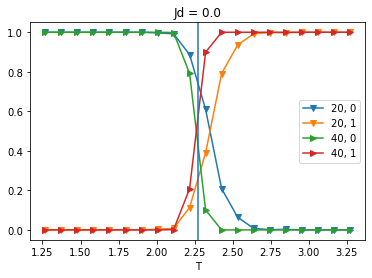

In [100]:
#plt.plot(T, outp_10_0, marker='o', label='10, 0')
#plt.plot(T, outp_10_1, marker='o', label='10, 1')

plt.plot(T, outp_20_0, marker='v', label='20, 0')
plt.plot(T, outp_20_1, marker='v', label='20, 1')

#plt.plot(T, outp_30_0, marker='<', label='30, 0')
#plt.plot(T, outp_30_1, marker='<', label='30, 1')

plt.plot(T, outp_40_0, marker='>', label='40, 0')
plt.plot(T, outp_40_1, marker='>', label='40, 1')

plt.title('Jd = 0.0')
plt.xlabel('T')
#plt.ylabel('MSE error')
plt.axvline(x=T_c)
plt.legend()
plt.show()

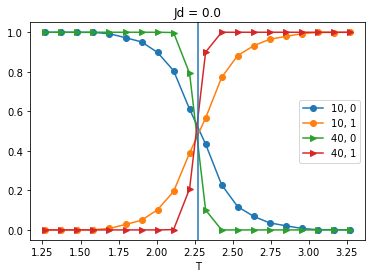

In [101]:
plt.plot(T, outp_10_0, marker='o', label='10, 0')
plt.plot(T, outp_10_1, marker='o', label='10, 1')

#plt.plot(T, outp_20_0, marker='v', label='20, 0')
#plt.plot(T, outp_20_1, marker='v', label='20, 1')

#plt.plot(T, outp_30_0, marker='<', label='30, 0')
#plt.plot(T, outp_30_1, marker='<', label='30, 1')

plt.plot(T, outp_40_0, marker='>', label='40, 0')
plt.plot(T, outp_40_1, marker='>', label='40, 1')

plt.title('Jd = 0.0')
plt.xlabel('T')
#plt.ylabel('MSE error')
plt.axvline(x=T_c)
plt.legend()
plt.show()